##  <font style="color:black">**Curso de Analytics de Imagens e Vídeos**</font>

Aula 08 - Classificação de imagens usando RNAs

## **Exemplo prático**

Criação e treinamento de rede neural com Pytorch

In [1]:
# Importação das bibliotecas

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms

torch.__version__

'2.0.1'

### Funções auxiliares para a execução

In [2]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy()

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

### Base de dados

In [3]:
# Especificando o transformador das imagens para o formato específico do pytorch (média = 0.5 e desvio padrão 0.5)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [4]:
# baixando base de dados de placas de transito
import urllib.request
import os.path
if not os.path.exists("GTSRB_Final_Training_Images.zip"):
    url = ("https://sid.erda.dk/public/archives/"
    + "daaeac0d7ce1152aea9b61d9f1e19370/"
    + "GTSRB_Final_Training_Images.zip")
    filename = "./GTSRB_Final_Training_Images.zip"
    urllib.request.urlretrieve(url, filename)

IMG_SIZE = 28
TEST_SIZE = 0.2

In [5]:
# lê o arquivo e separa os datasets de treinamento e teste
import zipfile
from skimage.transform import resize
from imageio import imread
from PIL import Image

X, Xt, y, yt = list(), list(), list(), list()

archive = zipfile.ZipFile(
          'GTSRB_Final_Training_Images.zip', 'r')
file_paths = [file for file in archive.namelist()
              if '.ppm' in file]

for filename in file_paths:
    with archive.open(filename) as img_file:
        img = Image.open(img_file).convert('L')
    img = np.array(img, dtype=np.uint8)
    img = resize(img,
                 output_shape=(IMG_SIZE, IMG_SIZE),
                 mode='reflect', anti_aliasing=True)

    img = (img * 255).astype(np.uint8)
    img_class = int(filename.split('/')[-2])

    if (hash(filename) % 1000) / 1000 > TEST_SIZE:
        X.append(img)
        y.append(img_class)
    else:
        Xt.append(img)
        yt.append(img_class)


archive.close()

In [6]:
from torch.utils.data import TensorDataset, DataLoader

tensor_x_treino = torch.from_numpy(np.array(X, dtype=np.uint8)).to(torch.float32) / 255.
tensor_x_teste = torch.from_numpy(np.array(Xt, dtype=np.uint8)).to(torch.float32) / 255.

tensor_y_treino = torch.from_numpy(np.array(y)).to(torch.long)
tensor_y_teste = torch.from_numpy(np.array(yt)).to(torch.long)

tensor_x_treino = (tensor_x_treino - 0.5) / 0.5
tensor_x_teste  = (tensor_x_teste  - 0.5) / 0.5

dataset_treino = TensorDataset(tensor_x_treino,tensor_y_treino)
dataset_teste = TensorDataset(tensor_x_teste,tensor_y_teste)

trainloader = DataLoader(dataset_treino, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(dataset_teste, batch_size=64, shuffle=False, num_workers=2)


In [7]:
# Visualizando uma imagem percorrendo o dataloader
# (1, 1, 28, 28)

image, label = next(iter(trainloader))
#imshow(image[0])
print(image[0].dtype)

torch.float32


Label	| Description

0	    | T-shirt/top | Camiseta/Blusa

### Criando uma rede neural

In [8]:
# Criação da classe queno formato especificado pelo pytorch
# Classifier é o nome escolhido para a o objeto
# dados de entrada (28x28 = 784)
# RNA totalmente conectada
# saída: 10 classes (camisas, sapatos, etc.)

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()

        # Camadas lineares para as conexões
        self.fc1 = nn.Linear(784, 256) # camada intermediaria 1
        self.fc2 = nn.Linear(256, 128) # camada intermediaria 2
        self.fc3 = nn.Linear(128, 64)  # camada intermediaria 3
        self.fc4 = nn.Linear(64, 43)   # camada de saida


    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        x = F.relu(self.fc1(x)) # Aplciação da função relu apos o somatório linear
        x = F.relu(self.fc2(x)) # Aplciação da função relu apos o somatório linear
        x = F.relu(self.fc3(x)) # Aplciação da função relu apos o somatório linear

        x = self.fc4(x)         # Não é necessário aplicação da função de ativação na última camada, pois iremos calcular as probabilidades com esta saída

        return x

In [9]:
# Criando objeto da estrutura da rede

net = Classifier()
print(net)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=43, bias=True)
)


In [10]:
# Onde estão os pesos da rede?
# Os pesos estão entre [-1, 1]

print(net.fc1.weight)
print(' ')
print(net.fc1.weight.shape)

Parameter containing:
tensor([[ 8.1515e-03,  1.3033e-02, -3.2232e-02,  ...,  2.5016e-03,
          1.4350e-02,  8.3795e-03],
        [-2.4256e-02,  1.8194e-02, -1.4510e-03,  ..., -2.3760e-02,
          2.8663e-02, -1.3897e-02],
        [-2.9045e-02,  5.2122e-03, -1.9632e-02,  ..., -1.3536e-02,
          3.2695e-02,  1.4780e-02],
        ...,
        [ 1.5073e-02, -3.4832e-02, -2.7780e-02,  ...,  1.9376e-02,
         -5.4938e-04, -1.3524e-02],
        [ 1.0909e-02,  1.3154e-02,  1.5703e-02,  ...,  9.9462e-05,
          2.7522e-02,  2.4271e-02],
        [ 3.3606e-02,  1.5176e-02, -5.3596e-03,  ...,  1.3361e-03,
         -1.5927e-02, -1.9288e-02]], requires_grad=True)
 
torch.Size([256, 784])


In [11]:
# Definindo parâmetros importantes do treinamento
#Função de custo e função de otimização dos parâmetros
# Faz-se necessário passar os parâmetros da rede e a taxa de aprendizado (learning rate)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Etapa de treinamento

In [12]:
# verificando disponibilidade da gpu
device = torch.device('cuda') if torch.cuda.is_available else torch.devide('cpu')
device

device(type='cuda')

## Adiciona a rede para a GPU

In [13]:
net.to(device)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=43, bias=True)
)

In [14]:
import torch
import torch.nn.functional as F


loss_train = []
loss_test = []
acc_train = []
acc_test = []

def training_loop(net, loader, optimizer, criterion, device, epoch, train=True):
    """
    Função de treino/teste de uma época.

    Args:
        net: modelo PyTorch
        loader: DataLoader (treino ou teste)
        optimizer: otimizador (apenas usado se train=True)
        criterion: função de perda
        device: 'cuda' ou 'cpu'
        epoch: número da época (para log)
        train: se True faz backprop, se False apenas avalia
    """
    running_loss = 0.0
    running_accuracy = 0.0

    if train:
        net.train()
    else:
        net.eval()

    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        outputs = net(inputs)  # logits crus (não aplicar softmax)

        loss = criterion(outputs, labels)

        if train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item()

        # Cálculo da acurácia
        # Softmax não necessário para acurácia, mas vamos pegar a classe com maior logit
        _, preds = torch.max(outputs, dim=1)
        equals = preds == labels
        accuracy = torch.mean(equals.float())
        running_accuracy += accuracy.item()

    # Média por batch
    avg_loss = running_loss / len(loader)
    avg_acc = running_accuracy / len(loader)

    fase = "Treinando" if train else "Testando"
    print(f"{fase}... ÉPOCA {epoch+1:3d} FINALIZADA: perda {avg_loss:.6f} - acurácia {avg_acc:.5f}")

    if train:
        loss_train.append((epoch, avg_loss))
        acc_train.append((epoch, avg_acc))
    else:
        loss_test.append((epoch, avg_loss))
        acc_test.append((epoch, avg_acc))

    return avg_loss, avg_acc


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

num_epochs = 100
for epoch in range(num_epochs):
    # Treino
    training_loop(net, trainloader, optimizer, criterion, device, epoch, train=True)
    # Validação/teste
    training_loop(net, testloader, optimizer, criterion, device, epoch, train=False)


Treinando... ÉPOCA   1 FINALIZADA: perda 3.697370 - acurácia 0.04793
Testando... ÉPOCA   1 FINALIZADA: perda 3.561559 - acurácia 0.04713
Treinando... ÉPOCA   2 FINALIZADA: perda 3.496327 - acurácia 0.05563
Testando... ÉPOCA   2 FINALIZADA: perda 3.491073 - acurácia 0.06888
Treinando... ÉPOCA   3 FINALIZADA: perda 3.439141 - acurácia 0.07773
Testando... ÉPOCA   3 FINALIZADA: perda 3.422861 - acurácia 0.08662
Treinando... ÉPOCA   4 FINALIZADA: perda 3.356600 - acurácia 0.09957
Testando... ÉPOCA   4 FINALIZADA: perda 3.331729 - acurácia 0.12750
Treinando... ÉPOCA   5 FINALIZADA: perda 3.256260 - acurácia 0.13516
Testando... ÉPOCA   5 FINALIZADA: perda 3.209406 - acurácia 0.16212
Treinando... ÉPOCA   6 FINALIZADA: perda 3.081700 - acurácia 0.16605
Testando... ÉPOCA   6 FINALIZADA: perda 2.988763 - acurácia 0.19287
Treinando... ÉPOCA   7 FINALIZADA: perda 2.801379 - acurácia 0.21452
Testando... ÉPOCA   7 FINALIZADA: perda 2.684153 - acurácia 0.24125
Treinando... ÉPOCA   8 FINALIZADA: perda 

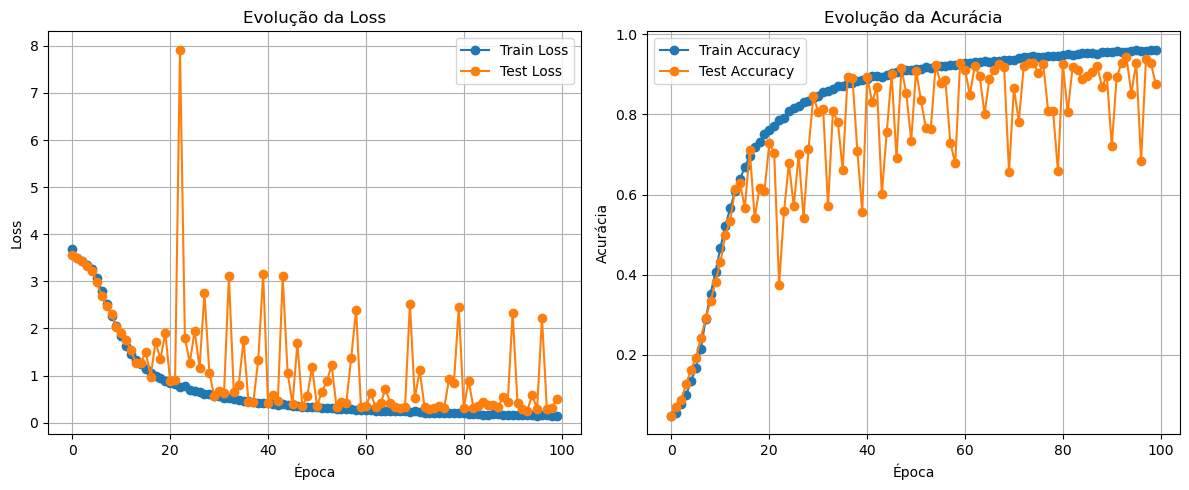

In [16]:
import matplotlib.pyplot as plt

# Separando épocas e valores
epochs_loss_train, values_loss_train = zip(*loss_train)
epochs_acc_train, values_acc_train   = zip(*acc_train)
epochs_loss_test, values_loss_test   = zip(*loss_test)
epochs_acc_test, values_acc_test     = zip(*acc_test)

plt.figure(figsize=(12,5))

# --- Gráfico de Loss ---
plt.subplot(1,2,1)
plt.plot(epochs_loss_train, values_loss_train, label="Train Loss", marker='o')
plt.plot(epochs_loss_test, values_loss_test, label="Test Loss", marker='o')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Evolução da Loss")
plt.legend()
plt.grid(True)

# --- Gráfico de Acurácia ---
plt.subplot(1,2,2)
plt.plot(epochs_acc_train, values_acc_train, label="Train Accuracy", marker='o')
plt.plot(epochs_acc_test, values_acc_test, label="Test Accuracy", marker='o')
plt.xlabel("Época")
plt.ylabel("Acurácia")
plt.title("Evolução da Acurácia")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Avaliação do Modelo

In [17]:
print(tensor_x_treino.min(), tensor_x_treino.max())
print(tensor_x_teste.min(), tensor_x_teste.max())
print(tensor_y_treino.min(), tensor_y_treino.max())
print(tensor_y_teste.min(), tensor_y_teste.max())


tensor(-0.9765) tensor(1.)
tensor(-0.9686) tensor(1.)
tensor(0) tensor(42)
tensor(0) tensor(42)


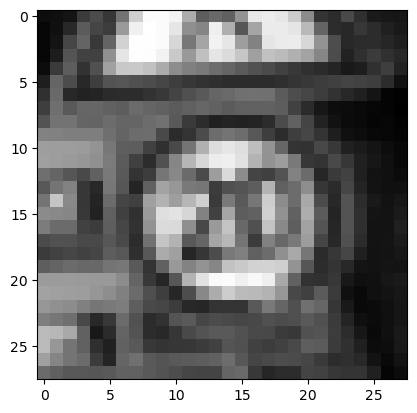

In [18]:
# Percorrendo as imagens do loader de teste e pegando uma imagem unica

imagem = next(iter(testloader))[0][0].view(28,28)
plt.imshow(imagem, cmap='gray')

In [19]:
imagem.shape

torch.Size([28, 28])

In [20]:
# Formatando imagem para o shape requerido pelo pytorch

imagem = imagem.view(1, 1, 28, 28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [21]:
# Colocando a rede no modo eval e passando para gpu

net.eval()
imagem = imagem.to(device)

In [22]:
# Realizando previsão

previsao = net.forward(imagem)

In [23]:
# verificando respostas
# Estes valores são chamados de 'score'.

print(previsao)

tensor([[ 38.3116,  38.0392,  29.7017,   8.4514,  24.7625,  13.4588,  -4.9236,
          14.5308,  15.0298,   6.8891, -17.5560,   4.5755,  15.7640,  -8.6522,
         -23.5062,  12.5501,  -4.6515,   6.7774, -15.5999,   9.4920,  -7.5049,
          -0.8293, -28.0576,  -8.8094,  -0.7745, -21.4732,  -9.6071, -13.9299,
           1.7500,   9.9592, -24.8404,  -0.2629,   4.2579,   4.9336, -18.9476,
         -16.1376,  -6.4943,   8.9362, -34.3952,   5.5351,  12.7276, -10.2178,
         -15.8312]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [24]:
# Aplicando softmax nos scores para gerar as probabilidades

prob = F.softmax(previsao, dim=1)

print(prob)

tensor([[5.6762e-01, 4.3228e-01, 1.0347e-04, 6.1085e-14, 7.4089e-07, 9.1331e-12,
         9.4889e-20, 2.6678e-11, 4.3943e-11, 1.2806e-14, 3.0979e-25, 1.2666e-15,
         9.1571e-11, 2.2800e-21, 8.0705e-28, 3.6808e-12, 1.2457e-19, 1.1453e-14,
         2.1906e-24, 1.7292e-13, 7.1808e-21, 5.6931e-18, 8.5166e-30, 1.9484e-21,
         6.0138e-18, 6.1636e-27, 8.7742e-22, 1.1637e-23, 7.5081e-17, 2.7590e-13,
         2.1256e-28, 1.0031e-17, 9.2195e-16, 1.8121e-15, 7.7038e-26, 1.2795e-24,
         1.9728e-20, 9.9187e-14, 1.5062e-32, 3.3068e-15, 4.3961e-12, 4.7641e-22,
         1.7383e-24]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [25]:
# Selecionando apenas os resultados

prob = prob.cpu().detach().numpy()

print(prob)

[[5.67618132e-01 4.32277650e-01 1.03472368e-04 6.10850549e-14
  7.40887742e-07 9.13313175e-12 9.48887638e-20 2.66782846e-11
  4.39431339e-11 1.28059786e-14 3.09791446e-25 1.26656170e-15
  9.15705012e-11 2.28004965e-21 8.07053962e-28 3.68083298e-12
  1.24568205e-19 1.14525250e-14 2.19060895e-24 1.72924256e-13
  7.18079610e-21 5.69306850e-18 8.51657431e-30 1.94837082e-21
  6.01376642e-18 6.16356516e-27 8.77419415e-22 1.16373494e-23
  7.50813446e-17 2.75896629e-13 2.12562986e-28 1.00314021e-17
  9.21946870e-16 1.81206627e-15 7.70384982e-26 1.27954639e-24
  1.97280573e-20 9.91871515e-14 1.50615621e-32 3.30679926e-15
  4.39607985e-12 4.76406303e-22 1.73827058e-24]]


In [26]:
# verificando o resultado

resultado = np.argmax(prob)

print(f'A classe predita é: {resultado}')

classes = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}


print('\n Classe: ' + classes[resultado])

A classe predita é: 0

 Classe: Speed limit (20km/h)


0 | Speed limit (20km/h)

1 | Speed limit (30km/h)

2 | Speed limit (50km/h)

3 | Speed limit (60km/h)

4 | Speed limit (70km/h)

5 | Speed limit (80km/h)

6 | End of speed limit (80km/h)

7 | Speed limit (100km/h)

8 | Speed limit (120km/h)

9 | No passing

10 | No passing for vehicles over 3.5 metric tons

11 | Right-of-way at the next intersection

12 | Priority road

13 | Yield

14 | Stop

15 | No vehicles

16 | Vehicles over 3.5 metric tons prohibited

17 | No entry

18 | General caution

19 | Dangerous curve to the left

20 | Dangerous curve to the right

21 | Double curve

22 | Bumpy road

23 | Slippery road

24 | Road narrows on the right

25 | Road work

26 | Traffic signals

27 | Pedestrians

28 | Children crossing

29 | Bicycles crossing

30 | Beware of ice/snow

31 | Wild animals crossing

32 | End of all speed and passing limits

33 | Turn right ahead

34 | Turn left ahead

35 | Ahead only

36 | Go straight or right

37 | Go straight or left

38 | Keep right

39 | Keep left

40 | Roundabout mandatory

41 | End of no passing

42 | End of no passing by vehicles over 3.5 metric ton